In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
import seaborn as sns
palette = {
    'negative': '#B10026',
    'neutral': '#FFAA00',
    'positive': '#228B3B'
}


In [2]:
df = pd.read_csv('chatgpt_clean_sentiment.csv',low_memory=False)
df_demoji = pd.read_csv('chatgpt_clean_demoji.csv',low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'chatgpt_clean_demoji.csv'

## Temporal Analysis

In [37]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')  
df['date_only'] = df['date'].dt.date
tweets_per_day = df.groupby('date_only').size().reset_index(name='count')
fig = px.line(tweets_per_day, x='date_only', y='count', labels={'date_only': 'Date', 'count': 'Number of Tweets'}, title='Number of Tweets per Day')
fig.show()

In [38]:
daily_sentiment = df.groupby(['date_only', 'predicted_label']).size().reset_index(name='count')
daily_sentiment_pivot = daily_sentiment.pivot(index='date_only', columns='predicted_label', values='count').reset_index()

fig = px.line(daily_sentiment_pivot, 
              x='date_only', 
              y=['negative', 'neutral', 'positive'],
              labels={'date_only': 'Date', 'value': 'Number of Tweets', 'variable': 'Sentiment'},
              title='Number of Tweets per Day by Sentiment')

# Update line colors
fig.data[0].line.color = palette['negative']
fig.data[1].line.color = palette['neutral']
fig.data[2].line.color = palette['positive']
fig.show()

In [63]:
# Calculate daily mean and standard deviation for positive and negative sentiments
daily_mean = df.groupby('date_only')[['positive', 'negative']].mean().reset_index()
daily_std = df.groupby('date_only')[['positive', 'negative']].std().reset_index()

# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Daily Average Positive Sentiment', 'Daily Average Negative Sentiment'))

# Add trace for positive sentiment mean
fig.add_trace(
    go.Scatter(x=daily_mean['date_only'], y=daily_mean['positive'], name='Positive Sentiment Mean'),
    row=1, col=1
)

# Add line for positive sentiment mean
fig.add_shape(type="line",
    x0=daily_mean['date_only'].values[0], y0=daily_mean['positive'].mean(), x1=daily_mean['date_only'].values[-1], y1=daily_mean['positive'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
    name='Mean'
)

# Add trace for negative sentiment mean
fig.add_trace(
    go.Scatter(x=daily_mean['date_only'], y=daily_mean['negative'], name='Negative Sentiment Mean'),
    row=2, col=1
)

# Add line for negative sentiment mean
fig.add_shape(type="line",
    x0=daily_mean['date_only'].values[0], y0=daily_mean['negative'].mean(), x1=daily_mean['date_only'].values[-1], y1=daily_mean['negative'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
    name='Mean',
    xref='x2', 
    yref='y2'
)

# Update layout
fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

https://www.scientificamerican.com/article/chatgpt-explains-why-ais-like-chatgpt-should-be-regulated1/
https://www.washingtonpost.com/opinions/interactive/2022/chatgpt-questions-predictions-ethics/
https://www.forbes.com/sites/bernardmarr/2022/12/28/what-does-chatgpt-really-mean-for-businesses/

In [68]:
# Calculate the 95th percentile for positive and negative scores
positive_threshold = df['positive'].quantile(0.95)
negative_threshold = df['negative'].quantile(0.95)

# Identify the most extreme positive and negative tweets
most_extreme_positive = df[df['positive'] >= positive_threshold]
most_extreme_negative = df[df['negative'] >= negative_threshold]

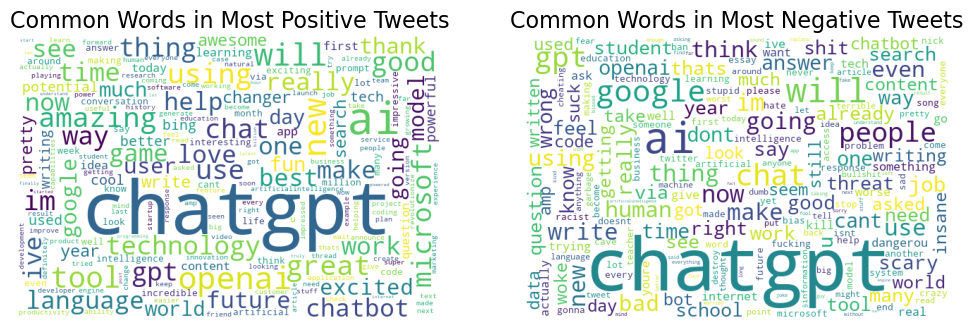

In [74]:
from wordcloud import WordCloud

# Combine text from most positive and most negative tweets
Most_Positive_text = ' '.join(most_extreme_positive['Text'])
Most_Negative_text = ' '.join(most_extreme_negative['Text'])

# Generate word clouds
pwc = WordCloud(width=600, height=400, collocations=False, background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600, height=400, collocations=False, background_color='white').generate(Most_Negative_text)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Common Words in Most Positive Tweets', fontsize=16)
plt.imshow(pwc)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Common Words in Most Negative Tweets', fontsize=16)
plt.imshow(nwc)
plt.axis('off')

plt.show()

In [75]:
# Count the number of extreme positive and negative tweets per day
extreme_positive_counts = most_extreme_positive['date_only'].value_counts().sort_index()
extreme_negative_counts = most_extreme_negative['date_only'].value_counts().sort_index()

# Create a DataFrame to hold the counts
extreme_counts = pd.DataFrame({
    'date_only': extreme_positive_counts.index.union(extreme_negative_counts.index),
    'extreme_positive': extreme_positive_counts,
    'extreme_negative': extreme_negative_counts
}).fillna(0)

# Plot the counts
fig = px.line(extreme_counts, x='date_only', y=['extreme_positive', 'extreme_negative'],
              labels={'date_only': 'Date', 'value': 'Number of Extreme Tweets', 'variable': 'Sentiment'},
              title='Number of Extreme Positive and Negative Tweets per Day')

fig.show()

## Demoji

用plotly绘图，使用子图，分别对df和df_demoji的label分布进行可视化

In [39]:
# Create subplots with specs parameter
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Tweets Sentiment Distribution', 'Tweets Sentiment Distribution After Demoji'),
                    specs=[[{"type": "pie"}, {"type": "pie"}]])

# Plot for all tweets
label_counts = df['predicted_label'].value_counts()
colors = [palette[label] for label in label_counts.index]
fig.add_trace(
    go.Pie(labels=label_counts.index, 
           values=label_counts.values,
           marker_colors=colors,
           textinfo='label+percent'),
    row=1, col=1
)

# Plot for tweets with emoji
emoji_label_counts = df_demoji[df_demoji['emoji'].notna()]['predicted_label'].value_counts()
colors_emoji = [palette[label] for label in emoji_label_counts.index]
fig.add_trace(
    go.Pie(labels=emoji_label_counts.index, 
           values=emoji_label_counts.values,
           marker_colors=colors_emoji,
           textinfo='label+percent'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=500,
    width=1000,
    showlegend=True,
    title_text="Sentiment Distribution Comparison",
    title_x=0.5,
    title_font_size=20
)

fig.show()

In [40]:
df['score'] = df[['negative', 'neutral', 'positive']].max(axis=1)
df_demoji['score'] = df_demoji[['negative', 'neutral', 'positive']].max(axis=1)

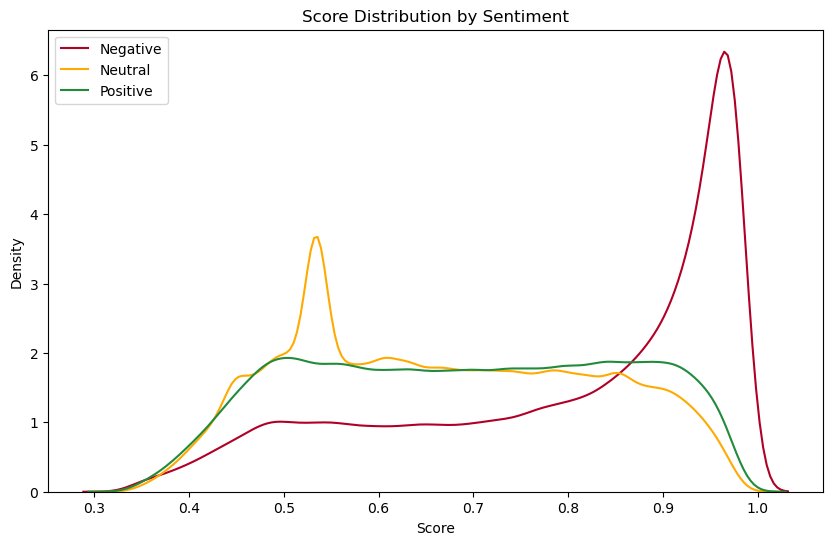

In [41]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['predicted_label'] == 'negative']['negative'], label='Negative', color=palette['negative'])
sns.kdeplot(df[df['predicted_label'] == 'neutral']['neutral'], label='Neutral', color=palette['neutral'])
sns.kdeplot(df[df['predicted_label'] == 'positive']['positive'], label='Positive', color=palette['positive'])

plt.title('Score Distribution by Sentiment')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

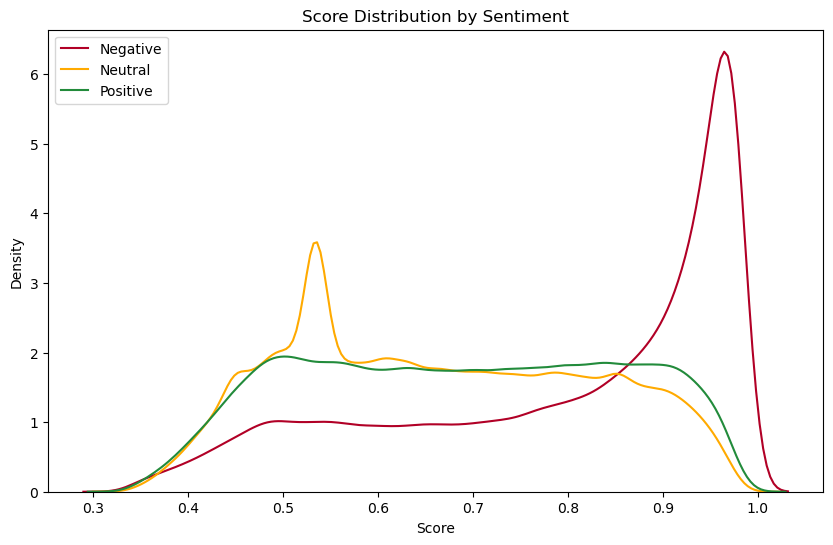

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_demoji[df_demoji['predicted_label'] == 'negative']['negative'], label='Negative', color=palette['negative'])
sns.kdeplot(df_demoji[df_demoji['predicted_label'] == 'neutral']['neutral'], label='Neutral', color=palette['neutral'])
sns.kdeplot(df_demoji[df_demoji['predicted_label'] == 'positive']['positive'], label='Positive', color=palette['positive'])

plt.title('Score Distribution by Sentiment')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

No significant difference observed, so we focus on tweets with emojis

In [43]:
# Select rows in df_demoji where emoji column has values
df_demoji_with_emoji = df_demoji[df_demoji['emoji'].notna()]
# Select corresponding rows in df
df_with_emoji = df[df.index.isin(df_demoji_with_emoji.index)]

In [56]:
# Calculate the Shannon entropy
def shannon_entropy(p):
    return -np.sum(p * np.log2(p + 1e-9))  

df_with_emoji.loc[:, 'entropy'] = df_with_emoji[['negative', 'neutral', 'positive']].apply(shannon_entropy, axis=1)
df_demoji_with_emoji.loc[:, 'entropy'] = df_demoji_with_emoji[['negative', 'neutral', 'positive']].apply(shannon_entropy, axis=1)

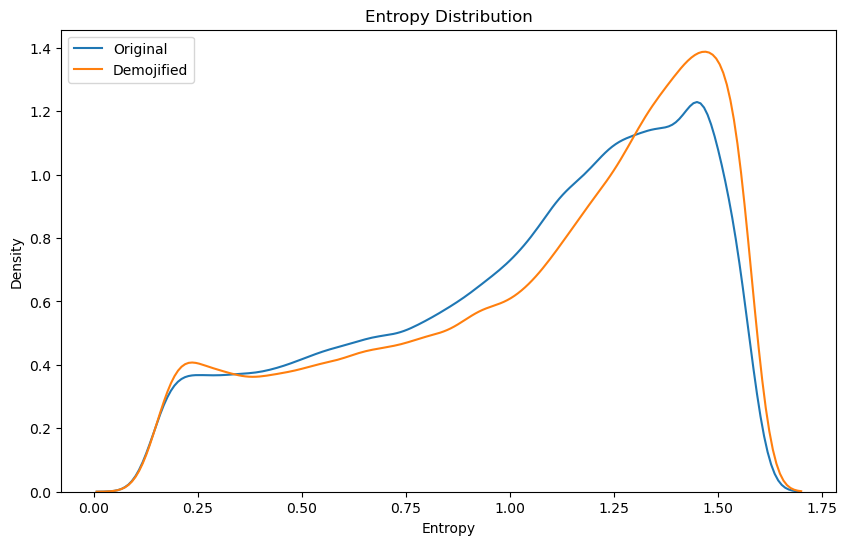

In [ ]:
#sns.kdeplot for entropy
plt.figure(figsize=(10, 6))
sns.kdeplot(df_with_emoji['entropy'], label='Original')
sns.kdeplot(df_demoji_with_emoji['entropy'], label='Demojified')
plt.title('Entropy Distribution')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

In [60]:
#piared t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(df_with_emoji['entropy'], df_demoji_with_emoji['entropy'])
print(f'T-statistic: {t_stat:.4f} | P-value: {p_value:.4f}')

T-statistic: -18.7070 | P-value: 0.0000


## Tweets per country or city

In [46]:
tweets_per_country = df['location'].value_counts().loc[lambda x: x > 3700].reset_index(name='counts')
tweets_per_country.columns = ['country', 'counts']

fig = px.bar(
    tweets_per_country,
    x='country',
    y='counts',
    labels={'country': 'Country or City', 'counts': 'Number of Tweets'},
    title='Number of Tweets per Country',
)

fig.update_layout(xaxis_tickangle=45)
fig.show()

## Emojis

In [47]:
df_demoji.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975450 entries, 0 to 975449
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             975227 non-null  object 
 1   emoji            125629 non-null  object 
 2   negative         975450 non-null  float64
 3   neutral          975450 non-null  float64
 4   positive         975450 non-null  float64
 5   predicted_label  975450 non-null  object 
 6   date             975450 non-null  object 
 7   likes            975450 non-null  int64  
 8   location         705265 non-null  object 
 9   followers        975450 non-null  int64  
 10  following        975450 non-null  int64  
 11  retweets         975450 non-null  int64  
 12  replies          975450 non-null  int64  
 13  score            975450 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 104.2+ MB


125629 Tweets with emojis

In [48]:
emoji_series = df_demoji['emoji'].dropna().explode().explode()
emoji_flattened = emoji_series.apply(lambda x: eval(x) if isinstance(x, str) else x).explode()
emoji_counts = emoji_flattened.value_counts()
#top 15 emojis
fig = px.bar(emoji_counts.head(15), x=emoji_counts.head(15).index, y=emoji_counts.head(15).values, labels={'x': 'Emoji', 'y': 'Count'}, title='Top 15 Emojis')
fig.show()

## Word Cloud

In [49]:
import spacy
from collections import Counter
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize text using spaCy
def spacy_lemmatize(text):
    if not isinstance(text, str):
        text = ""
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['spacy_lemmatized_text'] = df['Text'].progress_apply(spacy_lemmatize)
joined_text = ' '.join(df['spacy_lemmatized_text'])
word_freq = Counter(joined_text.split())
#remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
word_freq = {key: value for key, value in word_freq.items() if key not in stop_words}
#sort by frequency
word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

ModuleNotFoundError: No module named 'spacy'

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

with open('chatgpt_word_freq.pkl', 'rb') as f:
    word_freq = pickle.load(f)

word_freq['ChatGPT'] = word_freq.pop('chatgpt')
word_freq['AI'] = word_freq.pop('ai')
word_freq['OpenAI'] = word_freq.pop('openai')
word_freq['Google'] = word_freq.pop('google')
mask = np.array(Image.open(path.join("openai-mask-md/openai-mask-md.png")))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()